<a href="https://colab.research.google.com/github/SandeshBashyal/Pytorch_Offical_Tutorials/blob/main/Training_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training with PyTorch

OBJECTIVES:

1. We’ll get familiar with the dataset and dataloader abstractions, and how they ease the process of feeding data to your model during a training loop

2. We’ll discuss specific loss functions and when to use them

3. We’ll look at PyTorch optimizers, which implement algorithms to adjust model weights based on the outcome of a loss function

## Dataset and DataLoader

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime


transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Create datasets for training & validation, download if necessary
training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False)

# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

100%|██████████| 26421880/26421880 [00:01<00:00, 18197692.06it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 337315.76it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 6058629.55it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 17413126.61it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Training set has 60000 instances
Validation set has 10000 instances


T-shirt/top  Ankle Boot  Sneaker  Trouser


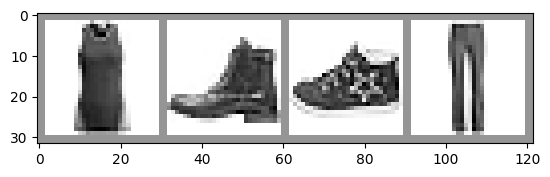

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(4)))

## The Model

In [3]:
import torch.nn as nn
import torch.nn.functional as F

# PyTorch models inherit from torch.nn.Module
class GarmentClassifier(nn.Module):
    def __init__(self):
        super(GarmentClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = GarmentClassifier()


## Loss Function

In [4]:
loss_fn = torch.nn.CrossEntropyLoss()

# NB: Loss functions expect data in batches, so we're creating batches of 4
# Represents the model's confidence in each of the 10 classes for a given input
dummy_outputs = torch.rand(4, 10)
# Represents the correct class among the 10 being tested
dummy_labels = torch.tensor([1, 5, 3, 7])

print(dummy_outputs)
print(dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print('Total loss for this batch: {}'.format(loss.item()))

tensor([[0.5565, 0.6994, 0.3721, 0.7649, 0.7643, 0.6257, 0.4951, 0.9807, 0.8997,
         0.8181],
        [0.8682, 0.5051, 0.1217, 0.8038, 0.2332, 0.4188, 0.1570, 0.8606, 0.4199,
         0.8976],
        [0.8322, 0.2720, 0.9449, 0.8550, 0.1856, 0.6343, 0.5581, 0.8163, 0.6984,
         0.6356],
        [0.8088, 0.2889, 0.2899, 0.7797, 0.7960, 0.2853, 0.7159, 0.4631, 0.8247,
         0.9852]])
tensor([1, 5, 3, 7])
Total loss for this batch: 2.3454768657684326


## Optimizer

In [5]:
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# Learning rate determines the size of the steps the optimizer takes.
# Momentum nudges the optimizer in the direction of strongest gradient over multiple steps.
# Different optimization algorithms, such as averaged SGD, Adagrad, or Adam.

# The Training Loop

On each pass loop does:

1. Gets a batch of training data from the DataLoader

2. Zeros the optimizer’s gradients

3. Performs an inference - that is, gets predictions from the model for an input batch

4. Calculates the loss for that set of predictions vs. the labels on the dataset

5. Calculates the backward gradients over the learning weights

6. Tells the optimizer to perform one learning step - that is, adjust the model’s learning weights based on the observed gradients for this batch, according to the optimization algorithm we chose

7. It reports on the loss for every 1000 batches.

8. Finally, it reports the average per-batch loss for the last 1000 batches, for comparison with a validation run

In [6]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

### Pre-Epoch Activity

There are a couple of things to do once per epoch:

1. Perform validation by checking our relative loss on a set of data that was not used for training, and report this

2. Save a copy of the model

In [7]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
  batch 1000 loss: 1.9469795555621385
  batch 2000 loss: 0.9761425277516246
  batch 3000 loss: 0.798207093517296
  batch 4000 loss: 0.7028451155740768
  batch 5000 loss: 0.6543727115672082
  batch 6000 loss: 0.6217079947199673
  batch 7000 loss: 0.5856084550581873
  batch 8000 loss: 0.5412153514670208
  batch 9000 loss: 0.5270600351840258
  batch 10000 loss: 0.5347068883953616
  batch 11000 loss: 0.5036254395146389
  batch 12000 loss: 0.4896124368360033
  batch 13000 loss: 0.4971573341875337
  batch 14000 loss: 0.4670034707095474
  batch 15000 loss: 0.4494861945634475
LOSS train 0.4494861945634475 valid 0.4873256981372833
EPOCH 2:
  batch 1000 loss: 0.4289640054111369
  batch 2000 loss: 0.4265112399935024
  batch 3000 loss: 0.41927226942376
  batch 4000 loss: 0.42919951029791265
  batch 5000 loss: 0.3976927884233883
  batch 6000 loss: 0.4004024268113426
  batch 7000 loss: 0.39886477312626084
  batch 8000 loss: 0.37537834709213347
  batch 9000 loss: 0.4013066749431891
  batch 1

## Other Resources

https://pytorch.org/tutorials/beginner/introyt/trainingyt.html#other-resources

1. Docs on the [data utilities](https://pytorch.org/docs/stable/data.html), including Dataset and DataLoader, at pytorch.org

2. A note on the use of pinned memory for GPU training : [CUDA Semantics](https://pytorch.org/docs/stable/notes/cuda.html#)

3. Documentation on the datasets available in TorchVision, TorchText, and TorchAudio

4. Documentation on the loss functions available in PyTorch

5. Documentation on the torch.optim package, which includes optimizers and related tools, such as learning rate scheduling

6. A detailed tutorial on saving and loading models

7. The Tutorials section of pytorch.org contains tutorials on a broad variety of training tasks, including classification in different domains, generative adversarial networks, reinforcement learning, and more